In [3]:
!pip install transformers
!pip install pytorch-nlp

In [4]:
## Librairies

from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import copy
import random
from tqdm import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchnlp.datasets import imdb_dataset
import matplotlib.ticker as mtick



In [15]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [24]:
## Paramètres

MAX_SEQ_LEN = 512
LENGTH_BATCH=200
BATCH_SIZE=10
TOP=5 
epochs=20
lr=0.001

model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
## Fonctions utiles


# Masquage de 15% d'un texte
def Masks(Tokens):
  L_indice=torch.zeros_like(Tokens).to(device)
  tokenised_new=copy.deepcopy(Test_tokenised)## Masques 

  for i in range (len(Tokens)):
      for proba in range (int(0.15 * float(Tokens[i].tolist().index(102)))):
          mask_indice=random.randrange(start=1, stop=Tokens[i].tolist().index(102)-1)
          tokenised_new["input_ids"][i][mask_indice]=103
          L_indice[i][mask_indice]=1
  return(tokenised_new,Input_tokenised,L_indice)

# Création Matrice Pseudo-Attention (prend en compte les mots voisins à poids égals)
def matrice_pseudo_attention_cbow(weight,L_size):
    att=np.c_[np.zeros(L_size) ,weight*np.identity(L_size)[:,:-1] ] + weight*np.identity(L_size) + weight*np.c_[np.identity(L_size)[:,1:], np.zeros(L_size) ] 
    # Traiter cas windowsize pair (rajouter une Identité sur la droite)
    return(torch.from_numpy(att))


# Calcul de l'accuracy
def accuracy_score(Y_model,verite_terrain):
    score=0
    for i in range (len(Y_model)): #pour chaque mot masqué
        y_top=(-Y_model[i]).argsort()[:TOP]  #les mots les plus probables selon Y
        if verite_terrain[i] in y_top:
            score+=1
    return(score/len(Y_model))



In [1]:
# Load the imdb training dataset

train= imdb_dataset(train=True)
test= imdb_dataset(test=True)


NameError: name 'imdb_dataset' is not defined

In [ ]:
Input_sentences=[]
Test_sentences=[]
for i in range(len(train)):
    Input_sentences.append(list(train[i].values())[0])
    Test_sentences.append(list(test[i].values())[0])

Input_sentences=Input_sentences[:LENGTH_BATCH]
Test_sentences=Test_sentences[:LENGTH_BATCH]

In [27]:
## Tokeniser

Input_tokenised=tokenizer.batch_encode_plus(Input_sentences,return_tensors="pt",padding="max_length", max_length=MAX_SEQ_LEN, truncation=True).to(device)
Test_tokenised=tokenizer.batch_encode_plus(Test_sentences,return_tensors="pt",padding="max_length", max_length=MAX_SEQ_LEN, truncation=True).to(device)

In [28]:
## Masking

Input_tokenised_new,Input_tokenised,L_indice=Masks(Input_tokenised["input_ids"])
Test_tokenised_new,Input_tokenised,L_indice2=Masks(Test_tokenised["input_ids"])

In [29]:
## Modèle

class MLM(nn.Module):
    def __init__(self,bert):
        super(MLM, self).__init__()

        self.embedding= nn.Embedding(30522,768)

        self.v = nn.Linear(768, 30522,bias = False)

        self.v.weight = torch.nn.Parameter(model.bert.embeddings.word_embeddings.weight,requires_grad=True)

        #trouver comment faire du parameter sharing

    def forward(self, tokens):
        emb_init = self.embedding(tokens) #Premiere représentation des tokens
        A=matrice_pseudo_attention_cbow(1,emb_init.shape[1]).to(device)
        emb_init_context=torch.matmul(A.float(),emb_init)
        return self.v(emb_init_context)


## Création du modèle (avec paramètres)

cbow=MLM(model)

loss_function = nn.MSELoss()
loss_function2= nn.MSELoss()
optimizer = torch.optim.SGD(cbow.parameters(), lr )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [30]:
## Batchs des données 

class TextDataset(Dataset):

    def __init__(self, X, M, torch_verite_terrain):
        self.inputs = X
        self.masques = M
        self.verite_terrain=torch_verite_terrain

    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        return (self.inputs[index],self.masques[index],self.verite_terrain[index])
    

#Création des batchs

data_train= TextDataset( 
    Input_tokenised_new["input_ids"],
    L_indice,
    Input_tokenised["input_ids"]
)


data_test= TextDataset( 
    Test_tokenised_new["input_ids"],
    L_indice2,
    Test_tokenised["input_ids"]
)

train_loader = DataLoader(data_train,batch_size=BATCH_SIZE,shuffle=False)
test_loader = DataLoader(data_test,batch_size=BATCH_SIZE,shuffle=False)


In [31]:
## Training

cbow.to(device)
model.to(device)
losses=[]
total_accuracy_train=[]
total_accuracy_test=[]


for epoch in range(epochs):
    cbow.zero_grad()
    total_loss = 0  

    for batch in tqdm((train_loader)):

        X,M,verite_terrain = batch

        with torch.no_grad():
            Y_bert=model(X).logits.squeeze()
        
        Y_model=cbow(X)
        
        loss_real=loss_function(Y_model,F.one_hot(verite_terrain , num_classes=30522).to(torch.float32))
        loss_bert=loss_function2(Y_model[M==1],Y_bert[M==1])
        loss = loss_bert + loss_real
        total_loss+=loss_bert.item() + loss_real.item()

        accuracy_train=accuracy_score(Y_model[M==1],verite_terrain[M==1])

        loss.backward()
        optimizer.step()
    
           
    for batch_test in (test_loader):
        X_test,M_test,verite_terrain_test = batch_test
        Y_model_test=cbow(X_test)
        accuracy_test=accuracy_score(Y_model_test[M_test==1],verite_terrain_test[M_test==1])


    print("Precision train: " + str(round(accuracy_train*100.,2)) + "% ")
    print("Precision test: " + str(round(accuracy_test*100.,2)) + "% ") 
 
    losses.append(total_loss)
    total_accuracy_train.append(accuracy_train)
    total_accuracy_test.append(accuracy_test)


100%|██████████| 20/20 [08:30<00:00, 25.53s/it]


Precision train: 0.0% 
Precision test: 0.0% 


  5%|▌         | 1/20 [00:27<08:40, 27.42s/it]


KeyboardInterrupt: 

In [ ]:
## Evolution de l'accuracy train

plt.figure()
plt.plot(total_accuracy_train*100)
plt.title('Accuracy train')
plt.xlabel("Nombres d'époques")
plt.ylabel("Accuracy (en %)")


Precision finale de 11.02% 


In [ ]:
## Evolution de l'accuracy test

plt.figure()
plt.plot(total_accuracy_test*100)
plt.title('Accuracy train')
plt.xlabel("Nombres d'époques")
plt.ylabel("Accuracy (en %)")

Saves/CBOW_initial


In [ ]:
## Evolution de la fonction de cout

plt.figure()
plt.plot(losses)
plt.title('Loss fonction')
plt.xlabel("Nombres d'époques")
plt.ylabel("Mean square error")


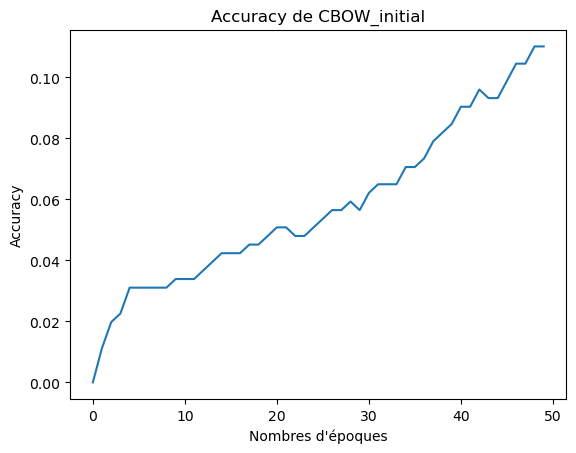

In [ ]:
## Création du dossier de sauvegarde

Nom='CBOW_initial'

Dossier=os.path.join('Saves/',Nom)
if not os.path.exists(Dossier):
    os.makedirs(Dossier)

## Sauvegardes des paramètres 

nbr_parameters= sum([np.prod(p.size()) for p in cbow.parameters()])

parameters=np.array([[nbr_parameters],
                     [MLM(model)],
                     [ str(round(score*100.,2)) + "% "],
                    [epochs],
                    [lr]])

lignes_param = ['Nombres de Paramètres: ', 'Model', 'accuracy','Epoques: ','Learning rate: ']

param_df = pd.DataFrame(data = parameters,index = lignes_param)

param_df.to_csv(Dossier + '/Paramètres' +str(Nom)  + '.csv',sep =';')


plt.plot(total_accuracy_train*100)
plt.savefig(Dossier +'/' + "Accuracy_train" + str(Nom) + ".png")
plt.plot(total_accuracy_test*100)
plt.savefig(Dossier +'/' + "Accuracy_test" + str(Nom) + ".png")

plt.plot(losses)
plt.savefig(Dossier +'/' + "LossFonction_" + str(Nom) + ".png")
